# Goal
* Generate many functions. 
    * Model the function with an MLP and fit with 300 epochs
    * Use the MLP to find $dydx$ and $d2y/d2x$ using `torch.autograd.grad`.
    * Use the  range of -1 to 1
    * Calculate the expected $dydx$ and $d2y/d2x$ for each function using sympy
    * Compare the L1 error between the analytical values and the MLP evaluted values for $dydx$ and $d2y/d2x$ 
    * Record the error values 
    * Plot the performance of the MLP to model the function and its deriviates


In [564]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [565]:
%matplotlib inline

In [597]:
def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, _input):
        return mish(_input)
    
class Sine(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, _input):
        return torch.sin(_input)
    
def make_batch(x): return x[:,None]

def debatch(x, detach = True):
    x =  x.squeeze()
    if detach: x = x.detach()
    return x

def make_mlp(n = 20, layers_count = 3, act = Mish):
    layers = []
    layers.append(nn.Linear(1,n))
    layers.append(act())
    for i in range(layers_count -2):
        layers.append(nn.Linear(n,n))
        layers.append(act())
    layers.append(nn.Linear(n,1))
    mlp = nn.Sequential(*layers)
    return mlp

class Stepper:
    clear_grad = True
    def __call__(self,my_mlp,xb, yb, lr = 1e-1):
        yprime = my_mlp(xb)
        self.loss = F.mse_loss(yb,yprime )
        self.loss.backward()
        for name, param in my_mlp.named_parameters():
            param.data = param.data - param.grad*lr
        if self.clear_grad: my_mlp.zero_grad()
        self.yprime = yprime
        return yprime.squeeze().detach()

In [598]:
do_step = Stepper()

# Randomly generate an equation

In [568]:
from  sympy import *
import random
import numpy as np
import warnings

In [569]:
x = symbols("x")

In [570]:
def add(x1,x2): return x1-x2
def minus(x1, x2): return x1-x2
def power(x1, x2): return x1**x2
def identity(x1): return x1

Here we are making a list of operations we might use. We break it up into two types of operations
* operations with just a single input
* operations with a input and a second number

In [571]:
fns = [cos, sin, identity]
fns2 = [add, minus, power]

Make an expression will combine together `number_of_num_fncs` of operations together. For each operation it will first randomly pick an operation in the list `fns` or `fns2` with the only difference being that for `fns2` operations, it will need to generate another random value as an additional argument to the operation.  

In [572]:
def make_equation(number_of_num_fncs):
    y  = 1
    for i in range(number_of_num_fncs):
        if random.randint(0,1)==0:
            fn = random.choice(fns)
            y = y*fn(x)
        else:
            fn = random.choice(fns2)
            value = random.random()-0.5
            y = y*fn(x,value)
#         print(i, y)
    return y
    

We call `make_equation` twice for the numerator and operator, then combine the results to make a whole equation. 

In [573]:
def make_whole_equation(possible_operations = 4, min_operations = 1):
    number_of_num_fncs_numerator = random.randint(min_operations,possible_operations)
    number_of_num_fncs_denominator = random.randint(min_operations,possible_operations)
#     print(number_of_num_fncs_numerator,number_of_num_fncs_denominator )
    numerator = make_equation(number_of_num_fncs_numerator)
    denominator = make_equation(number_of_num_fncs_numerator)
    equation = numerator/denominator
    return equation

In [574]:
equation = make_whole_equation()
equation

(x - 0.0398709874092558)/x

We take the symbolic equation and convert it to a numpy function using `lambdify`. Then we evalute the function at the points in `x_numeric` and then plot to see if everything is working. 

In [575]:
f = lambdify(x, equation, "numpy")

In [576]:
x_numeric = np.linspace(-1,1, 40)

In [577]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    y = f(x_numeric)

(-10.0, 10.0)

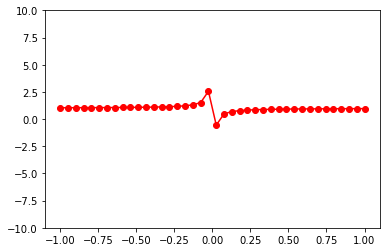

In [578]:
plt.plot(x_numeric, y, 'ro-')
plt.ylim([-10,10])

Next, we calculate the analytical first derivative. Then we turn the function into a numpy function, evalute, and plot. 

In [579]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
#     dydx = simplify( diff(equation, x))
    dydx =  diff(equation, x)

In [580]:
dydx

1/x - (x - 0.0398709874092558)/x**2

In [581]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    f_dydx = lambdify(x, dydx, "numpy")
    dydx_values = f_dydx(x_numeric)

(-10.0, 10.0)

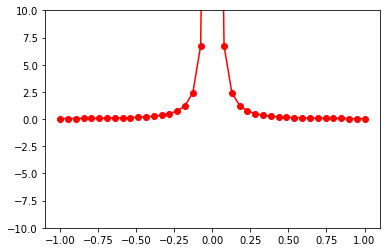

In [582]:
plt.plot(x_numeric, dydx_values, 'ro-')
plt.ylim([-10,10])

We do the same thing for hte 2nd derivative. 

In [583]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    d2yd2x =  diff(dydx, x)
    f_d2yd2x = lambdify(x, d2yd2x, "numpy")
    d2yd2x_values = f_d2yd2x(x_numeric)

(-10.0, 10.0)

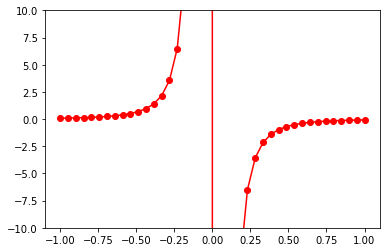

In [584]:
plt.plot(x_numeric, d2yd2x_values, 'ro-')
plt.ylim([-10,10])

In [585]:
# d2yd2x

## MLP
* make an mlp
* fit it to y values 
* measure the error for y, dydx, and d2yd2x

In [586]:
class Normalizer:
    def __init__(self, values):
        self.mean = values.mean()
        self.std = values.std()
    
    def norm(self, values):
        return  (values - self.mean)/self.std
    
    def denorm(self, values):
        return values*self.std+ self.mean

In [587]:
# mlp

Notes:
* convert nan's to 0 and infinity to a large number with `nan_to_num`
* convert to tensor
* convert to batch format
* convert to float32

In [588]:
# x_numeric_t, y_t = [torch.tensor(z) for z in  [x_numeric,y]]
xb, yb = [make_batch(torch.tensor(np.nan_to_num(z))).to(torch.float32) for z in [x_numeric,y]]
yb_normalizer = Normalizer(yb)
yb_norm = yb_normalizer.norm(yb)

In [589]:
# yb_norm

## Train the MLP
* a learning rate higher than 1e-2 is generally unstable. 

In [596]:
loss_fn = F.mse_loss

In [593]:
mlp = make_mlp(n = 100, layers_count=3, act = Mish)

In [594]:
for i in range(int(5e4)):
    yprime_out = do_step(mlp, xb, yb_norm, lr = 5e-3)
    loss = loss_fn(yprime_out, yb_norm)

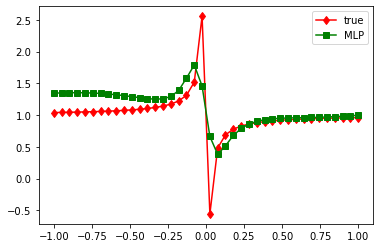

In [595]:
yprime = mlp(xb)

yprime_debatch = yb_normalizer.denorm(   debatch(yprime))
# x_debatch = debatch(x)

plt.plot(x_numeric,y, "rd-", label = "true")
plt.plot(x_numeric,yprime_debatch, "gs-", label = "MLP")
plt.legend()

In [533]:
# yb_norm

In [390]:
xb.requires_grad = True
yprime = mlp(xb)

dydx = torch.autograd.grad(yprime.sum(), xb, create_graph=True)[0]

d2yd2x = torch.autograd.grad(dydx.sum(), xb, create_graph=True)[0]

In [263]:
# yprime_debatch

In [264]:
# yprime

In [54]:
for i in range(300):
    yprime_out = do_step(mlp, xb, yb, lr = 1e-1)

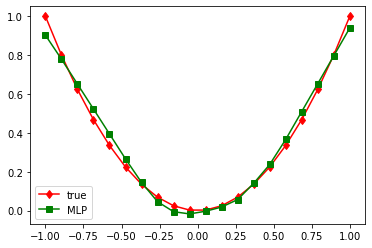

In [55]:
plt.plot(x,y, "rd-", label = "true")
plt.plot(x,yprime_out, "gs-", label = "MLP")
plt.legend()

In [58]:
xb.requires_grad = True
yprime = mlp(xb)

dydx = torch.autograd.grad(yprime.sum(), xb, create_graph=True)[0]

d2yd2x = torch.autograd.grad(dydx.sum(), xb, create_graph=True)[0]

In [59]:
# y, dydx_analytical, d2yd2x_analytical 

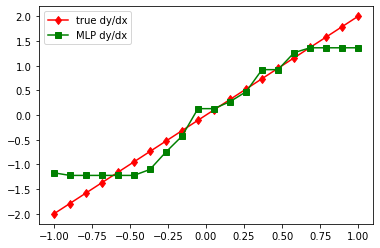

In [60]:
plt.plot(x,dydx_analytical, "rd-", label = "true dy/dx")
plt.plot(x,debatch(dydx), "gs-", label = "MLP dy/dx")
plt.legend()

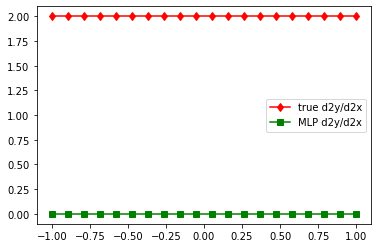

In [61]:
plt.plot(x,d2yd2x_analytical, "rd-", label = "true d2y/d2x")
plt.plot(x,debatch(d2yd2x), "gs-", label = "MLP d2y/d2x")
plt.legend()